## Assignment

In this assignment, you'll continue working with the Students Performance in Exams dataset from Kaggle. You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'studentsperformance'<br>

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?
2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.
3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns
%matplotlib inline

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from studentsperformance', con=engine)

engine.dispose()

### 1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

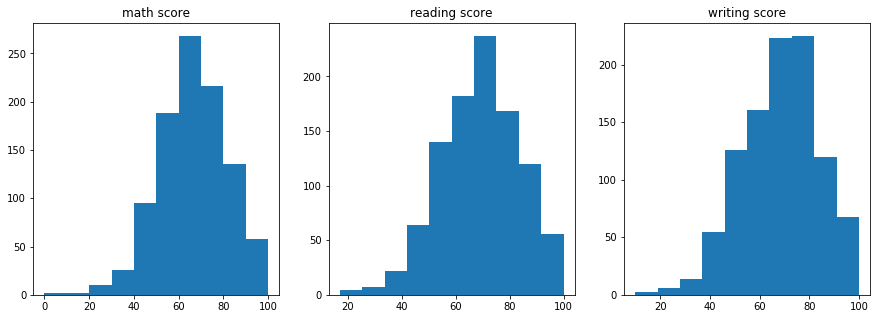

In [3]:
plt.figure(figsize=(15,5))
for i, col in enumerate(df.iloc[:, -3:], start=1):
    plt.subplot(1,3,i)
    plt.hist(df[col])
    plt.title(col)
plt.show()

In [4]:
for col in df.iloc[:, -3:]:
    print(col, stats.normaltest(df[col]))
    print(col, 'Jarque-Bera', stats.jarque_bera(df[col]))

math score NormaltestResult(statistic=15.408960513931822, pvalue=0.00045080293869937836)
math score Jarque-Bera (15.912256686712709, 0.0003505075386818213)
reading score NormaltestResult(statistic=11.11741279628622, pvalue=0.003853758403576582)
reading score Jarque-Bera (11.383300575987892, 0.0033740202672214448)
writing score NormaltestResult(statistic=13.606450837263859, pvalue=0.0011101885439899974)
writing score Jarque-Bera (13.98509448257235, 0.0009187033894586527)


These distributions appear 'like' normal, but using tests for normality we find that none of them are actually normal.

Zeros create problems for boxcox - there is only one zero in all the scores, so we'll drop the row (it's an outlier for all three tests anyway).

In [5]:
df[df['math score']==0]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
59,female,group C,some high school,free/reduced,none,0,17,10


In [6]:
df.drop(59, inplace=True)

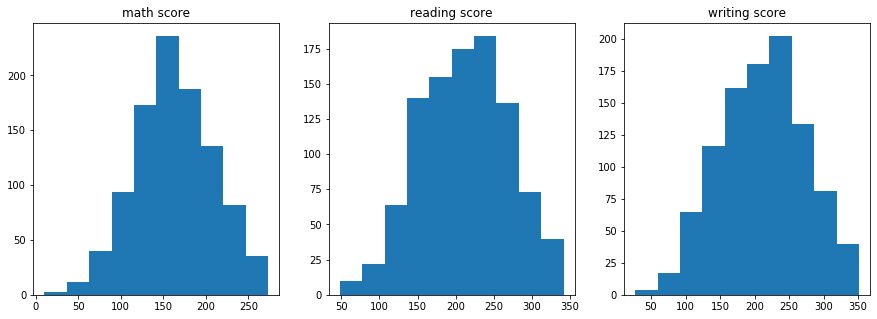

In [7]:
plt.figure(figsize=(15,5))
for i, col in enumerate(df.iloc[:, -3:], start=1):
    plt.subplot(1,3,i)
    plt.hist(stats.boxcox(df[col])[0])
    plt.title(col)
plt.show()

In [8]:
for col in df.iloc[:, -3:]:
    print(col, 'boxcox', stats.normaltest(stats.boxcox(df[col])[0]))
    print(col, 'boxcox', 'Jarque-Bera', stats.jarque_bera(stats.boxcox(df[col])[0]))

math score boxcox NormaltestResult(statistic=1.8323075851586939, pvalue=0.4000547794685686)
math score boxcox Jarque-Bera (1.7200982636836308, 0.42314129209599327)
reading score boxcox NormaltestResult(statistic=6.546500254297637, pvalue=0.03788310187455936)
reading score boxcox Jarque-Bera (4.8891540799411395, 0.08676282434883942)
writing score boxcox NormaltestResult(statistic=8.018367650263817, pvalue=0.018148201299612785)
writing score boxcox Jarque-Bera (5.762346713079429, 0.05606893537015201)


These features definitely become more normal (math is basically normal), but the other 2 still come up non normal based on the test for normality.

### 2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

In [9]:
exam_avg = (df['math score'] + df['reading score'] + df['writing score'])/3

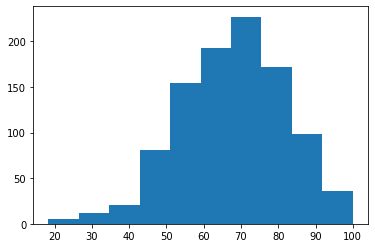

In [10]:
plt.hist(exam_avg)
plt.show()

In [11]:
print('exam average', stats.normaltest(exam_avg))
print('exam average', stats.jarque_bera(exam_avg))

exam average NormaltestResult(statistic=10.127189207749474, pvalue=0.006322790687068094)
exam average (10.345394363749879, 0.0056692571616785425)


Average of exams also appears to be non-normal, but 'like' normal.

In [12]:
bc_exam_avg = stats.boxcox(exam_avg)[0]

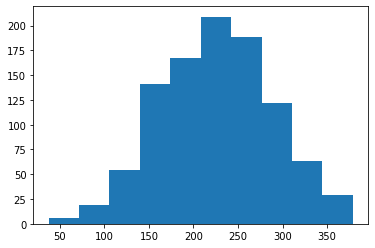

In [13]:
plt.hist(bc_exam_avg)
plt.show()

In [14]:
print('exam average boxcox', stats.normaltest(bc_exam_avg))
print('exam average boxcox', stats.jarque_bera(bc_exam_avg))

exam average boxcox NormaltestResult(statistic=4.219879978703656, pvalue=0.12124524222064059)
exam average boxcox (3.4323846909111793, 0.17974926966382276)


Appears that the boxcox transformation is good enough to be considered normal.

### 3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

In [15]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

Based on prior analysis - all variables except race/ethnicity seemed to have a significant significance on the scores of each individual test, so it is likely that they also determine overall score as well. We can reexamine this by using just our average exam scores now. 

In [16]:
df['exam score'] = exam_avg

In [17]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,exam score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


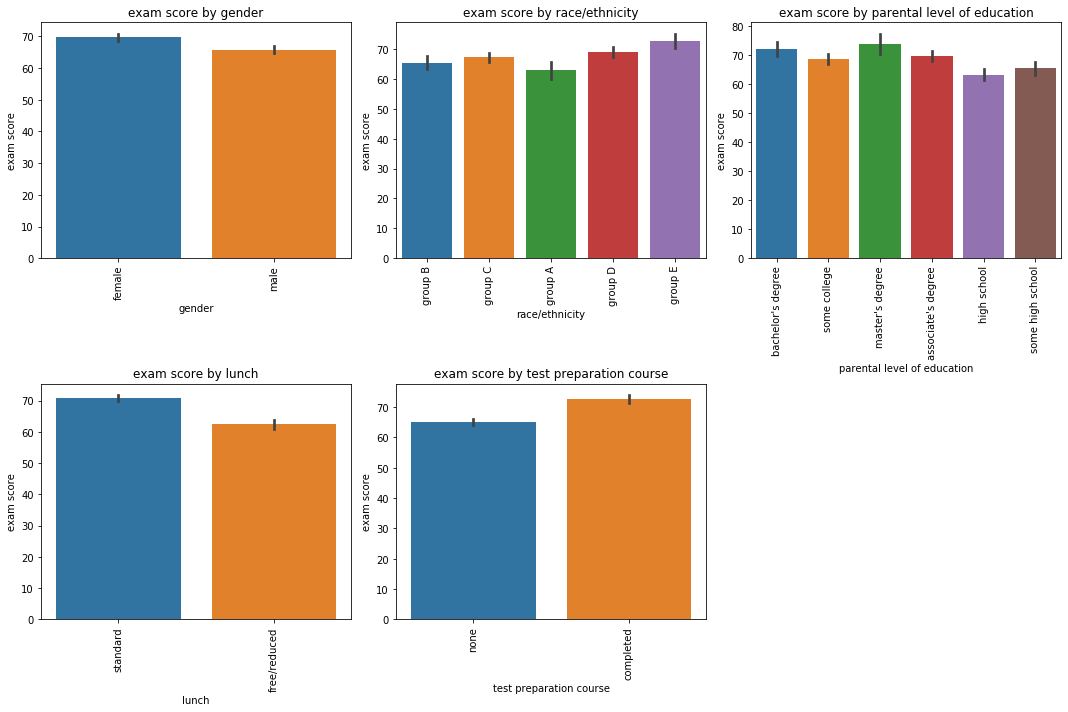

In [18]:
plt.figure(figsize=(15,10))
for i, col in enumerate(list(df.columns)[0:-4], start=1):
    plt.subplot(2,3,i)
    x = sns.barplot(col, 'exam score', data=df)
    for item in x.get_xticklabels():
        item.set_rotation(90)
    plt.title(str('exam score by '+ col))
plt.tight_layout()
plt.show()

In all reality, these could all be potential features, let's check their significance.

In [19]:
def significance(cat):
    uniques = df[cat].unique()
    for var in ['exam score']:
        print("------------------------------------------------")
        print("Comparisons for {}: {}".format(var, cat))
        print("------------------------------------------------")
        for i in range(0, len(uniques)):
            for j in range(i+1, len(uniques)):
                print("t-test between groups {0} and {1}:".format(uniques[i], uniques[j]))
                print(stats.ttest_ind(
                    df[df[cat]==uniques[i]][var], 
                    df[df[cat]==uniques[j]][var]
                ))

In [20]:
for col in list(df.columns)[0:-4]:
    significance(col)

------------------------------------------------
Comparisons for exam score: gender
------------------------------------------------
t-test between groups female and male:
Ttest_indResult(statistic=4.33677778857033, pvalue=1.592773074984749e-05)
------------------------------------------------
Comparisons for exam score: race/ethnicity
------------------------------------------------
t-test between groups group B and group C:
Ttest_indResult(statistic=-1.4405954858885, pvalue=0.15031746511041588)
t-test between groups group B and group A:
Ttest_indResult(statistic=1.3165043669633527, pvalue=0.18909305895094428)
t-test between groups group B and group D:
Ttest_indResult(statistic=-2.8031083992077255, pvalue=0.00527994920437489)
t-test between groups group B and group E:
Ttest_indResult(statistic=-4.46037807261396, pvalue=1.1254806793764281e-05)
t-test between groups group C and group A:
Ttest_indResult(statistic=2.628074738662737, pvalue=0.008913350965902764)
t-test between groups group

Based on significance, it would appear that many of these would be statistically different from one another, with few exceptions. So it may be best to test with all features first then perhaps eliminate some that don't work as well.